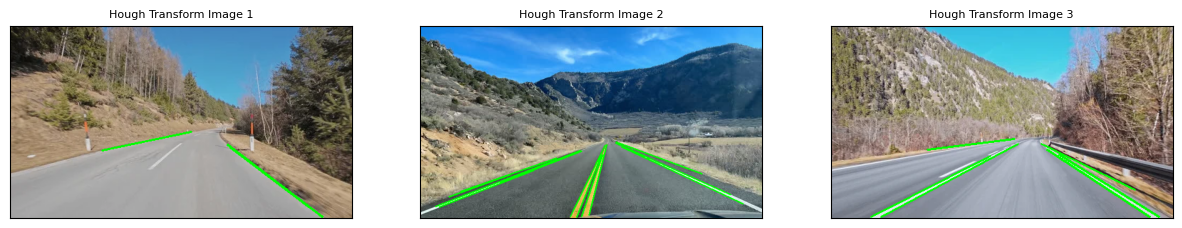

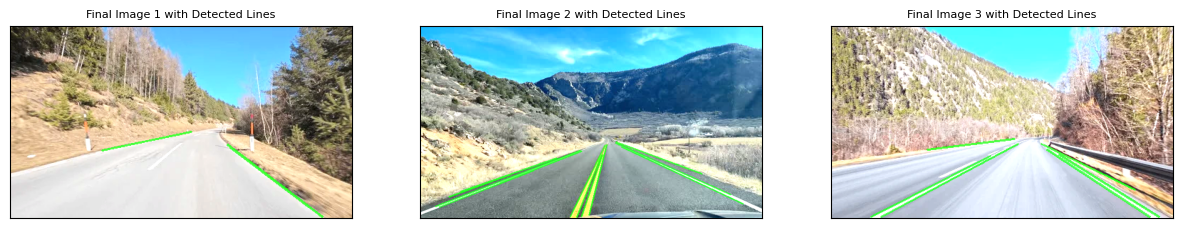

In [5]:
# Importing Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 01 - Import dashboard camera images
img1 = cv2.imread(r'images\\road1.webp', 1)
img2 = cv2.imread(r'images\\road4.jpg', 1)
img3 = cv2.imread(r'images\\road2.webp', 1)

# Step 02 - Convert sample images to Gray Scale
grayImg1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
grayImg2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
grayImg3 = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)

# Step 03 - Removing Noise of the Gray scale images (Image Pre-processing)
blurGrayImg15 = cv2.GaussianBlur(grayImg1, (5, 5), 0)
blurGrayImg13 = cv2.GaussianBlur(grayImg1, (3, 3), 0)
blurGrayImg25 = cv2.GaussianBlur(grayImg2, (5, 5), 0)
blurGrayImg23 = cv2.GaussianBlur(grayImg2, (3, 3), 0)
blurGrayImg35 = cv2.GaussianBlur(grayImg3, (5, 5), 0)
blurGrayImg33 = cv2.GaussianBlur(grayImg3, (3, 3), 0)

# Step 04 - Canny Edge Detection
lowThresholdValue = 50 
highThresholdValue = 150

cannyEdges15 = cv2.Canny(blurGrayImg15, lowThresholdValue, highThresholdValue)
cannyEdges13 = cv2.Canny(blurGrayImg13, lowThresholdValue, highThresholdValue)
cannyEdges25 = cv2.Canny(blurGrayImg25, lowThresholdValue, highThresholdValue)
cannyEdges23 = cv2.Canny(blurGrayImg23, lowThresholdValue, highThresholdValue)
cannyEdges35 = cv2.Canny(blurGrayImg35, lowThresholdValue, highThresholdValue)
cannyEdges33 = cv2.Canny(blurGrayImg33, lowThresholdValue, highThresholdValue)

# Step 05 - Masking the region of interest

def region_of_interest(img):
    height, width = img.shape[:2]
    mask = np.zeros_like(img)
    # Define a larger triangle region of interest with an even wider base
    triangle = np.array([[
        (0, height),                            # Bottom-left corner at the left edge
        (width, height),                        # Bottom-right corner at the right edge
        (int(0.5 * width), int(0.35 * height))  # Top corner remains the same
    ]], np.int32)
    cv2.fillPoly(mask, triangle, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

# Apply the region of interest mask to the edge-detected images
roiEdges15 = region_of_interest(cannyEdges15)
roiEdges13 = region_of_interest(cannyEdges13)
roiEdges25 = region_of_interest(cannyEdges25)
roiEdges23 = region_of_interest(cannyEdges23)
roiEdges35 = region_of_interest(cannyEdges35)
roiEdges33 = region_of_interest(cannyEdges33)

# Step 06 - Apply Hough Probabilistic Transform to detect lines
def hough_transform(image, original_image):
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold = 50, minLineLength = 100, maxLineGap = 10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(original_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return original_image

# Apply Hough Transform on the edge-detected images
houghImg1 = hough_transform(roiEdges15, img1.copy())
houghImg2 = hough_transform(roiEdges25, img2.copy())
houghImg3 = hough_transform(roiEdges35, img3.copy())

# Display the results
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.title('Hough Transform Image 1', fontsize = 8)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(houghImg1, cv2.COLOR_BGR2RGB))

plt.subplot(132)
plt.title('Hough Transform Image 2', fontsize = 8)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(houghImg2, cv2.COLOR_BGR2RGB))

plt.subplot(133)
plt.title('Hough Transform Image 3', fontsize = 8)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(houghImg3, cv2.COLOR_BGR2RGB))

plt.show()

# Step 07 - Draw the lines in the original images
def draw_lines_on_original(image, lines_image):
    final_image = cv2.addWeighted(image, 0.4, lines_image, 1, 0)
    return final_image

# Draw the detected lines on the original images
finalImg1 = draw_lines_on_original(img1, houghImg1)
finalImg2 = draw_lines_on_original(img2, houghImg2)
finalImg3 = draw_lines_on_original(img3, houghImg3)

# Display the final results
plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.title('Final Image 1 with Detected Lines', fontsize=8)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(finalImg1, cv2.COLOR_BGR2RGB))

plt.subplot(132)
plt.title('Final Image 2 with Detected Lines', fontsize=8)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(finalImg2, cv2.COLOR_BGR2RGB))

plt.subplot(133)
plt.title('Final Image 3 with Detected Lines', fontsize=8)
plt.xticks([]), plt.yticks([])
plt.imshow(cv2.cvtColor(finalImg3, cv2.COLOR_BGR2RGB))

plt.show()


Road Width: 6.04 meters


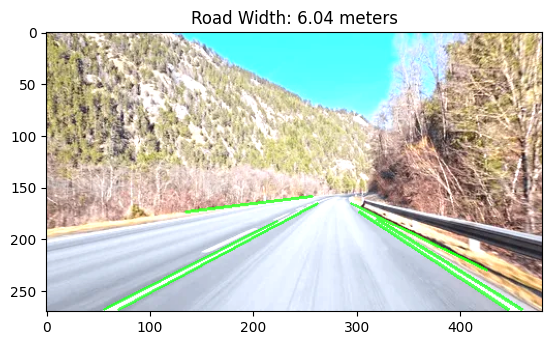

In [6]:
def measureRoadWidth(image, metersPerPixel):
    # Convert the image to HSV color space to detect green lines
    hsvImage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define the range for the color green in HSV
    lowerGreen = np.array([40, 40, 40])
    upperGreen = np.array([70, 255, 255])
    
    # Create a mask for green color
    greenMask = cv2.inRange(hsvImage, lowerGreen, upperGreen)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(greenMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    leftX = []
    rightX = []
    height = image.shape[0]
    
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if y > height * 0.8:  # Consider points near the bottom of the image
                if x < image.shape[1] // 2:
                    leftX.append(x)
                else:
                    rightX.append(x)
                    
    if leftX and rightX:
        roadWidthPixels = np.mean(rightX) - np.mean(leftX)
        roadWidthMeters = roadWidthPixels * metersPerPixel
    else:
        roadWidthMeters = 0
    
    return roadWidthMeters

# Example usage with a sample image and metersPerPixel value
# imagePath = 'path_to_your_image.jpg'
image = finalImg3
metersPerPixel = 0.020  # Replace with the actual meters per pixel value for your images

# meters per pixels = actual image size in meters/ image pixel value

roadWidth = measureRoadWidth(image, metersPerPixel)
print(f'Road Width: {roadWidth:.2f} meters')

# Display the image with detected green lines for verification
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f'Road Width: {roadWidth:.2f} meters')
plt.show()


In [7]:

def processFrame(frame, metersPerPixel):
    # Same steps as with the image: Convert to HSV, detect green lines, and measure road width
    hsvFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lowerGreen = np.array([36, 25, 25])
    upperGreen = np.array([86, 255, 255])
    
    # Create a mask for green color
    greenMask = cv2.inRange(hsvFrame, lowerGreen, upperGreen)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(greenMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    leftX = []
    rightX = []
    height = frame.shape[0]
    
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if y > height * 0.8:  # Consider points near the bottom of the frame
                if x < frame.shape[1] // 2:
                    leftX.append(x)
                else:
                    rightX.append(x)
                    
    if leftX and rightX:
        roadWidthPixels = np.mean(rightX) - np.mean(leftX)
        roadWidthMeters = roadWidthPixels * metersPerPixel
    else:
        roadWidthMeters = 0

    # Return the road width (in meters) and the greenMask to visualize the detected lines
    return roadWidthMeters, greenMask

# Video file path
videoPath = 'videos\\footage1_1920_1080_30fps.mp4'
cap = cv2.VideoCapture(videoPath)

# Get video dimensions and set meters per pixel
metersPerPixel = 0.021  # Your previously calculated value

# Define codec and create VideoWriter object to save the output video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_with_roadlines.avi', fourcc, 20.0, (640, 360))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process each frame and get the road width in meters
    roadWidthMeters, greenMask = processFrame(frame, metersPerPixel)
    
    # Overlay the road width text on the frame
    cv2.putText(frame, f'Road Width: {roadWidthMeters:.2f} meters', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Combine the green mask with the original frame for better visualization
    combinedFrame = cv2.addWeighted(frame, 1, cv2.cvtColor(greenMask, cv2.COLOR_GRAY2BGR), 0.3, 0)

    # Show the frame with the road width
    cv2.imshow('Road Line Detection', combinedFrame)
    out.write(combinedFrame)  # Write the frame to the output video

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()


In [8]:

def processFrame(frame, metersPerPixel):
    # Same steps as with the image: Convert to HSV, detect green lines, and measure road width
    hsvFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lowerGreen = np.array([36, 25, 25])
    upperGreen = np.array([86, 255, 255])
    
    # Create a mask for green color
    greenMask = cv2.inRange(hsvFrame, lowerGreen, upperGreen)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(greenMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    leftX = []
    rightX = []
    height = frame.shape[0]
    
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if y > height * 0.8:  # Consider points near the bottom of the frame
                if x < frame.shape[1] // 2:
                    leftX.append(x)
                else:
                    rightX.append(x)
                    
    if leftX and rightX:
        roadWidthPixels = np.mean(rightX) - np.mean(leftX)
        roadWidthMeters = roadWidthPixels * metersPerPixel
    else:
        roadWidthMeters = 0

    # Return the road width (in meters) and the greenMask to visualize the detected lines
    return roadWidthMeters, greenMask

# Video file path
videoPath = 'videos\\footage1_1920_1080_30fps.mp4'
cap = cv2.VideoCapture(videoPath)

# Get video dimensions and set meters per pixel
metersPerPixel = 0.02  # Your previously calculated value

# Define codec and create VideoWriter object to save the output video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_with_roadlines.avi', fourcc, 20.0, (640, 360))

# Variables for window size and video speed
windowSize = (640, 360)  # Adjust this as needed for a smaller display
playbackSpeed = 50  # Adjust the playback speed in milliseconds (higher values slow down the video)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process each frame and get the road width in meters
    roadWidthMeters, greenMask = processFrame(frame, metersPerPixel)
    
    # Resize the frame for display (smaller window)
    resizedFrame = cv2.resize(frame, windowSize)

    # Overlay the road width text on the frame
    cv2.putText(resizedFrame, f'Road Width: {roadWidthMeters:.2f} meters', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Combine the green mask with the original frame for better visualization
    combinedFrame = cv2.addWeighted(resizedFrame, 1, cv2.cvtColor(greenMask, cv2.COLOR_GRAY2BGR), 0.3, 0)

    # Show the frame with the road width
    cv2.imshow('Road Line Detection', combinedFrame)
    out.write(resizedFrame)  # Write the frame to the output video

    # Adjust the playback speed using cv2.waitKey()
    if cv2.waitKey(playbackSpeed) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

In [9]:
import cv2
import numpy as np
import datetime

def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

def region_of_interest(img):
    height, width = img.shape[:2]
    mask = np.zeros_like(img)
    triangle = np.array([[
        (0, height),                        
        (width, height),                    
        (int(0.5 * width), int(0.35 * height))  
    ]], np.int32)
    cv2.fillPoly(mask, triangle, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def hough_transform(image, original_frame):
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    line_img = np.zeros_like(original_frame)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return line_img

def measure_road_width(image, meters_per_pixel):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([36, 25, 25])
    upper_green = np.array([86, 255, 255])
    
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    
    contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    leftX = []
    rightX = []
    height = image.shape[0]
    
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if y > height * 0.8:  # Focus on points near the bottom of the frame
                if x < image.shape[1] // 2:
                    leftX.append(x)
                else:
                    rightX.append(x)
                    
    if leftX and rightX:
        road_width_pixels = np.mean(rightX) - np.mean(leftX)
        road_width_meters = road_width_pixels * meters_per_pixel
    else:
        road_width_meters = 0
    
    return road_width_meters

# Function to simulate dashcam-like interface
def add_dashcam_overlay(frame, road_width, speed=60, meters_per_pixel=0.021):
    # Road width in meters
    cv2.putText(frame, f'Road Width: {road_width:.2f} meters', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Simulate speed display
    cv2.putText(frame, f'Speed: {speed} km/h', (frame.shape[1] - 250, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Add timestamp
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    cv2.putText(frame, timestamp, (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Add Play and Pause buttons in the bottom-right corner
    play_btn_x = frame.shape[1] - 150
    play_btn_y = frame.shape[0] - 80
    pause_btn_x = frame.shape[1] - 80
    pause_btn_y = frame.shape[0] - 80

    # Draw Play button
    cv2.rectangle(frame, (play_btn_x, play_btn_y), (play_btn_x + 60, play_btn_y + 40), (255, 255, 255), -1)
    cv2.putText(frame, 'PLAY', (play_btn_x + 5, play_btn_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

    # Draw Pause button
    cv2.rectangle(frame, (pause_btn_x, pause_btn_y), (pause_btn_x + 60, pause_btn_y + 40), (255, 255, 255), -1)
    cv2.putText(frame, 'PAUSE', (pause_btn_x + 5, pause_btn_y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)

# Function to process the video with a dashcam interface
def process_video(video_path, meters_per_pixel, window_size=(640, 360), playback_speed=50):
    cap = cv2.VideoCapture(video_path)
    width, height = window_size

    # Create a VideoWriter to save the output
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_with_dashcam_overlay.avi', fourcc, 20.0, window_size)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        edges = preprocess_frame(frame)
        roi_edges = region_of_interest(edges)

        # Detect road lines and color them green
        hough_lines = hough_transform(roi_edges, frame.copy())

        # Overlay the lines on the original frame
        final_frame = cv2.addWeighted(frame, 0.8, hough_lines, 1, 0)

        # Measure the road width
        road_width = measure_road_width(final_frame, meters_per_pixel)

        # Add dashcam overlay
        add_dashcam_overlay(final_frame, road_width)

        # Resize the frame for display
        resized_frame = cv2.resize(final_frame, (width, height))
        
        # Show the frame with road width and dashcam-like UI
        cv2.imshow('Dashcam Road Line Detection', resized_frame)
        out.write(resized_frame)  # Save the output video
        
        # Adjust video speed
        if cv2.waitKey(playback_speed) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage example
video_path = 'videos\\vid6.mp4'
meters_per_pixel = 0.021  # Replace with your calculated value
window_size = (800, 450)  # Adjustable window size
playback_speed = 50  # Adjustable video playback speed

process_video(video_path, meters_per_pixel, window_size, playback_speed)

In [10]:
import cv2
import numpy as np
import datetime
import random

# Preprocess the frame to grayscale, blur, and apply Canny edge detection
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

# Define the region of interest for road detection
def region_of_interest(img):
    height, width = img.shape[:2]
    mask = np.zeros_like(img)
    triangle = np.array([[ (0, height), (width, height), (int(0.5 * width), int(0.35 * height)) ]], np.int32)
    cv2.fillPoly(mask, triangle, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

# Apply Hough Probabilistic Transform to detect lines
def hough_transform(image, original_frame):
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    line_img = np.zeros_like(original_frame)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return line_img

# Measure the road width using detected green lines
def measure_road_width(image, meters_per_pixel):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([36, 25, 25])
    upper_green = np.array([86, 255, 255])
    
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    leftX = []
    rightX = []
    height = image.shape[0]
    
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if y > height * 0.8:  # Focus on points near the bottom of the frame
                if x < image.shape[1] // 2:
                    leftX.append(x)
                else:
                    rightX.append(x)
                    
    if leftX and rightX:
        road_width_pixels = np.mean(rightX) - np.mean(leftX)
        road_width_meters = road_width_pixels * meters_per_pixel
    else:
        road_width_meters = 0
    
    return road_width_meters

# Function to simulate dashcam-like interface
def add_dashcam_overlay(frame, road_width, speed, car_width=2):
    # Road width in meters
    cv2.putText(frame, f'Road Width: {road_width:.2f} meters', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Simulate speed display (dynamic speed between 40 km/h and 50 km/h)
    cv2.putText(frame, f'Speed: {speed:.2f} km/h', (frame.shape[1] - 250, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Add timestamp
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    cv2.putText(frame, timestamp, (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Display warning if road width is less than the car width (2 meters)
    if road_width < car_width:
        cv2.putText(frame, 'Road is not enough wide', (frame.shape[1] // 2 - 200, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

# Function to process the video with a dashcam interface
def process_video(video_path, meters_per_pixel, window_size=(640, 360), playback_speed=50):
    cap = cv2.VideoCapture(video_path)
    width, height = window_size

    # Create a VideoWriter to save the output
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_with_dashcam_overlay.avi', fourcc, 20.0, window_size)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        edges = preprocess_frame(frame)
        roi_edges = region_of_interest(edges)

        # Detect road lines and color them green
        hough_lines = hough_transform(roi_edges, frame.copy())

        # Overlay the lines on the original frame
        final_frame = cv2.addWeighted(frame, 0.8, hough_lines, 1, 0)

        # Measure the road width
        road_width = measure_road_width(final_frame, meters_per_pixel)

        # Randomize speed between 40 km/h and 50 km/h
        speed = random.uniform(40, 50)

        # Add dashcam overlay (speed, road width, timestamp, warnings)
        add_dashcam_overlay(final_frame, road_width, speed)

        # Resize the frame for display
        resized_frame = cv2.resize(final_frame, (width, height))
        
        # Show the frame with road width and dashcam-like UI
        cv2.imshow('Real-time Dashcam View', resized_frame)
        out.write(resized_frame)  # Save the output video
        
        # Adjust video speed
        if cv2.waitKey(playback_speed) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage example
video_path = 'videos\\vid6.mp4'
meters_per_pixel = 0.020  # Replace with your calculated value
window_size = (800, 450)  # Adjustable window size
playback_speed = 50  # Adjustable video playback speed

process_video(video_path, meters_per_pixel, window_size, playback_speed)

In [12]:
import cv2
import numpy as np
import datetime
import random

# Preprocess the frame to grayscale, blur, and apply Canny edge detection
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

# Define the region of interest for road detection
def region_of_interest(img):
    height, width = img.shape[:2]
    mask = np.zeros_like(img)
    triangle = np.array([[ (0, height), (width, height), (int(0.5 * width), int(0.35 * height)) ]], np.int32)
    cv2.fillPoly(mask, triangle, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

# Apply Hough Probabilistic Transform to detect lines
def hough_transform(image, original_frame):
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    line_img = np.zeros_like(original_frame)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return line_img

# Measure the road width using detected green lines
def measure_road_width(image, meters_per_pixel):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([36, 25, 25])
    upper_green = np.array([86, 255, 255])
    
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    leftX = []
    rightX = []
    height = image.shape[0]
    
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if y > height * 0.8:  # Focus on points near the bottom of the frame
                if x < image.shape[1] // 3:
                    leftX.append(x)
                elif x > 2 * image.shape[1] // 3:
                    rightX.append(x)
                    
    if leftX and rightX:
        road_width_pixels = np.mean(rightX) - np.mean(leftX)
        road_width_meters = road_width_pixels * meters_per_pixel
    else:
        road_width_meters = 0
    
    return road_width_meters

# Function to simulate dashcam-like interface
def add_dashcam_overlay(frame, road_width, speed, car_width=2, frame_idx=0, total_frames=100):
    # Road width in meters
    cv2.putText(frame, f'Road Width: {road_width:.2f} meters', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Adjusted speed display to move it more toward the center
    cv2.putText(frame, f'Speed: {speed:.2f} km/h', (frame.shape[1] - 350, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Add timestamp
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    cv2.putText(frame, timestamp, (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Display warning if road width is less than the car width (2 meters)
    if road_width < car_width:
        cv2.putText(frame, 'Road is not enough wide', (frame.shape[1] // 2 - 200, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

    # Display frame reading process at the bottom-right corner
    frame_read_text = f'Reading Frame: {frame_idx}/{total_frames}'
    cv2.putText(frame, frame_read_text, (frame.shape[1] - 250, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Function to process the video with a dashcam interface
def process_video(video_path, meters_per_pixel, window_size=(640, 360), playback_speed=50):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total frame count
    frame_idx = 0
    
    width, height = window_size

    # Create a VideoWriter to save the output
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_with_dashcam_overlay.avi', fourcc, 20.0, window_size)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        edges = preprocess_frame(frame)
        roi_edges = region_of_interest(edges)

        # Detect road lines and color them green
        hough_lines = hough_transform(roi_edges, frame.copy())

        # Overlay the lines on the original frame
        final_frame = cv2.addWeighted(frame, 0.8, hough_lines, 1, 0)

        # Measure the road width
        road_width = measure_road_width(final_frame, meters_per_pixel)

        # Randomize speed between 40 km/h and 50 km/h
        speed = random.uniform(40, 50)

        # Add dashcam overlay (speed, road width, timestamp, warnings)
        add_dashcam_overlay(final_frame, road_width, speed, frame_idx=frame_idx, total_frames=total_frames)

        # Resize the frame for display
        resized_frame = cv2.resize(final_frame, (width, height))
        
        # Show the frame with road width and dashcam-like UI
        cv2.imshow('Real-time Dashcam View', resized_frame)
        out.write(resized_frame)  # Save the output video
        
        # Adjust video speed
        if cv2.waitKey(playback_speed) & 0xFF == ord('q'):
            break
        
        frame_idx += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage example
video_path = 'videos\\vid6.mp4'
meters_per_pixel = 0.020  # Replace with your calculated value
window_size = (800, 450)  # Adjustable window size
playback_speed = 50  # Adjustable video playback speed

process_video(video_path, meters_per_pixel, window_size, playback_speed)


In [19]:
import cv2
import numpy as np
import datetime
import random

# Preprocess the frame to grayscale, blur, and apply Canny edge detection
def preprocess_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

# Define the region of interest for road detection
def region_of_interest(img):
    height, width = img.shape[:2]
    mask = np.zeros_like(img)
    triangle = np.array([[ (0, height), (width, height), (int(0.5 * width), int(0.35 * height)) ]], np.int32)
    cv2.fillPoly(mask, triangle, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

# Apply Hough Probabilistic Transform to detect lines
def hough_transform(image, original_frame):
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    line_img = np.zeros_like(original_frame)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return line_img

# Measure the road width using detected green lines, excluding middle lines
def measure_road_width(image, meters_per_pixel):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([36, 25, 25])
    upper_green = np.array([86, 255, 255])
    
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    contours, _ = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    leftX = []
    rightX = []
    height = image.shape[0]
    width = image.shape[1]
    
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if y > height * 0.8:  # Focus on points near the bottom of the frame
                # Split the image into thirds: left, middle, and right
                if x < width // 3:  # Leftmost third of the image
                    leftX.append(x)
                elif x > 2 * width // 3:  # Rightmost third of the image
                    rightX.append(x)

    # Ensure we only take the outermost points (excluding middle lines)
    if leftX and rightX:
        leftmostX = np.min(leftX)  # Outermost point on the left
        rightmostX = np.max(rightX)  # Outermost point on the right
        
        # Calculate the road width in pixels and convert it to meters
        road_width_pixels = rightmostX - leftmostX
        road_width_meters = road_width_pixels * meters_per_pixel
    else:
        road_width_meters = 0
    
    return road_width_meters

# Function to simulate dashcam-like interface
def add_dashcam_overlay(frame, road_width, speed, car_width=2, frame_idx=0, total_frames=100):
    # Road width in meters
    cv2.putText(frame, f'Road Width: {road_width:.2f} meters', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Adjusted speed display to move it more toward the center
    cv2.putText(frame, f'Speed: {speed:.2f} km/h', (frame.shape[1] - 350, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Add timestamp
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    cv2.putText(frame, timestamp, (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Display warning if road width is less than the car width (2 meters)
    if road_width < car_width:
        cv2.putText(frame, 'Road is not enough wide', (frame.shape[1] // 2 - 200, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

    # Display frame reading process at the bottom-right corner, adjusted for visibility
    frame_read_text = f'Reading Frame: {frame_idx}/{total_frames}'
    cv2.putText(frame, frame_read_text, (frame.shape[1] - 300, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Function to process the video with a dashcam interface
def process_video(video_path, meters_per_pixel, window_size=(640, 360), playback_speed=50):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total frame count
    frame_idx = 0
    
    width, height = window_size

    # Create a VideoWriter to save the output
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_with_dashcam_overlay.avi', fourcc, 20.0, window_size)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        edges = preprocess_frame(frame)
        roi_edges = region_of_interest(edges)

        # Detect road lines and color them green
        hough_lines = hough_transform(roi_edges, frame.copy())

        # Overlay the lines on the original frame
        final_frame = cv2.addWeighted(frame, 0.8, hough_lines, 1, 0)

        # Measure the road width
        road_width = measure_road_width(final_frame, meters_per_pixel)

        # Randomize speed between 40 km/h and 50 km/h
        speed = random.uniform(40, 50)

        # Add dashcam overlay (speed, road width, timestamp, warnings)
        add_dashcam_overlay(final_frame, road_width, speed, frame_idx=frame_idx, total_frames=total_frames)

        # Resize the frame for display
        resized_frame = cv2.resize(final_frame, (width, height))
        
        # Show the frame with road width and dashcam-like UI
        cv2.imshow('Real-time Dashcam View', resized_frame)
        out.write(resized_frame)  # Save the output video
        
        # Adjust video speed
        if cv2.waitKey(playback_speed) & 0xFF == ord('q'):
            break
        
        frame_idx += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage example
video_path = 'videos\\vid6.mp4'
meters_per_pixel = 0.0120  # Replace with your calculated value
window_size = (800, 450)  # Adjustable window size
playback_speed = 50  # Adjustable video playback speed

process_video(video_path, meters_per_pixel, window_size, playback_speed)

In [4]:
# Image Implementation convert to Video footage  

import cv2
import numpy as np
import datetime
import random

# Preprocess the frame to grayscale, blur, and apply Canny edge detection
def preprocessFrame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

# Define the region of interest for road detection
def regionOfInterest(img):
    height, width = img.shape[:2]
    mask = np.zeros_like(img)
    triangle = np.array([[ (0, height), (width, height), (int(0.5 * width), int(0.35 * height)) ]], np.int32)
    cv2.fillPoly(mask, triangle, 255)
    maskedImg = cv2.bitwise_and(img, mask)
    return maskedImg

# Apply Hough Probabilistic Transform to detect lines
def houghTransform(image, originalFrame):
    lines = cv2.HoughLinesP(image, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=10)
    lineImg = np.zeros_like(originalFrame)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lineImg, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return lineImg

# Measure the road width using detected green lines, excluding middle lines
def measureRoadWidth(image, metersPerPixel):
    hsvImage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lowerGreen = np.array([36, 25, 25])
    upperGreen = np.array([86, 255, 255])
    
    greenMask = cv2.inRange(hsvImage, lowerGreen, upperGreen)
    contours, _ = cv2.findContours(greenMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    leftX = []
    rightX = []
    height = image.shape[0]
    width = image.shape[1]
    
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if y > height * 0.8:  # Focus on points near the bottom of the frame
                # Split the image into thirds: left, middle, and right
                if x < width // 3:  # Leftmost third of the image
                    leftX.append(x)
                elif x > 2 * width // 3:  # Rightmost third of the image
                    rightX.append(x)

    # Ensure we only take the outermost points (excluding middle lines)
    if leftX and rightX:
        leftmostX = np.min(leftX)  # Outermost point on the left
        rightmostX = np.max(rightX)  # Outermost point on the right
        
        # Calculate the road width in pixels and convert it to meters
        roadWidthPixels = rightmostX - leftmostX
        roadWidthMeters = roadWidthPixels * metersPerPixel
    else:
        roadWidthMeters = 0
    
    return roadWidthMeters

# Function to simulate dashcam-like interface
def addDashcamOverlay(frame, roadWidth, speed, carWidth=2, frameIdx=0, totalFrames=100):
    # Road width in meters
    cv2.putText(frame, f'Road Width: {roadWidth:.2f} meters', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Adjusted speed display to move it more toward the center
    cv2.putText(frame, f'Speed: {speed:.2f} km/h', (frame.shape[1] - 350, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Add timestamp
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    cv2.putText(frame, timestamp, (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Display warning if road width is less than the car width (2 meters)
    if roadWidth < carWidth:
        cv2.putText(frame, 'Road is not enough wide', (frame.shape[1] // 2 - 200, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

    # Display frame reading process at the bottom-right corner, adjusted for visibility
    frameReadText = f'Reading Frame: {frameIdx}/{totalFrames}'
    cv2.putText(frame, frameReadText, (frame.shape[1] - 300, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Function to process the video with a dashcam interface
def processVideo(videoPath, metersPerPixel, windowSize=(640, 360), playbackSpeed=50):
    cap = cv2.VideoCapture(videoPath)
    totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total frame count
    frameIdx = 0
    
    width, height = windowSize

    # Create a VideoWriter to save the output
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output_with_dashcam_overlay.avi', fourcc, 20.0, windowSize)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        edges = preprocessFrame(frame)
        roiEdges = regionOfInterest(edges)

        # Detect road lines and color them green
        houghLines = houghTransform(roiEdges, frame.copy())

        # Overlay the lines on the original frame
        finalFrame = cv2.addWeighted(frame, 0.8, houghLines, 1, 0)

        # Measure the road width
        roadWidth = measureRoadWidth(finalFrame, metersPerPixel)

        # Randomize speed between 40 km/h and 50 km/h
        speed = random.uniform(40, 50)

        # Add dashcam overlay (speed, road width, timestamp, warnings)
        addDashcamOverlay(finalFrame, roadWidth, speed, frameIdx=frameIdx, totalFrames=totalFrames)

        # Resize the frame for display
        resizedFrame = cv2.resize(finalFrame, (width, height))
        
        # Show the frame with road width and dashcam-like UI
        cv2.imshow('Real-time Dashcam View', resizedFrame)
        out.write(resizedFrame)  # Save the output video
        
        # Adjust video speed
        if cv2.waitKey(playbackSpeed) & 0xFF == ord('q'):
            break
        
        frameIdx += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()

# Usage example
videoPath = 'videos\\vid5.mp4'
metersPerPixel = 0.0120  # Replace with your calculated value
windowSize = (800, 450)  # Adjustable window size
playbackSpeed = 50  # Adjustable video playback speed

processVideo(videoPath, metersPerPixel, windowSize, playbackSpeed)